# DL Performance Experiment by Network Architecture 
---
### Dataset: Kaggle Home Credit Default Risk
### Date: 2018/07/04
### Author: Daekeun Kim
### Objective
- Tested on the several representative deep neural network architectures
- Network Architectures
    - Vanilla Net
    - ResNet
    - HighwayNet
    - DenseNet
- Renewed the highest record in modeling results based on deep learning (the previous record: 0.757 < 0.77 (ours))

In [4]:
from __future__ import print_function, division
import dlgan_tools.dl as hcc_dl
import dlgan_tools.preprocessing as hcc_pre
import dlgan_tools.eval as hcc_eval

import keras
from keras.layers import Add, Input, Concatenate, Dense, Reshape, Flatten, Dropout, multiply, concatenate, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.noise import GaussianNoise
from keras.models import Sequential, Model
from keras import losses, regularizers
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.losses import mse, binary_crossentropy
import keras.backend as K
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline 

PATH = "./dataset/home_credit/outputs"
print(os.listdir(PATH))

['credit_train_y.npy', '.DS_Store', 'credit_bureau_prev_train.npy', 'credit_bureau_prev_test.npy', 'credit_bureau_prev_columns.txt']


### Common Functions

In [5]:
def save_strlist(filename, my_list):
    with open(filename, mode='w', encoding='utf-8') as f:
        f.write('\n'.join(my_list))
        
        
def load_strlist(filename):
    with open(filename, mode='r', encoding='utf-8') as f:
        lines = f.read().splitlines()
    return lines


def save_df_columns(df, path, uniq_name):
    filename = '{}/{}_columns.txt'.format(path, uniq_name)
    save_strlist(filename, df.columns.values)
    
    cat_cols_object = df.dtypes[df.dtypes == 'object'].index
    cat_cols_int = df.dtypes[df.dtypes == 'int64'].index
    numeric_cols = df.dtypes[df.dtypes == 'float64'].index

    if cat_cols_object.empty is False:
        filename = '{}/{}_cat_obj_columns.txt'.format(path, uniq_name)
        save_strlist(filename, cat_cols_object.values)
            
    if cat_cols_int.empty is False:
        filename = '{}/{}_cat_int_columns.txt'.format(path, uniq_name)
        save_strlist(filename, cat_cols_int.values)  
            
    if numeric_cols.empty is False:
        filename = '{}/{}_numeric_columns.txt'.format(path, uniq_name)
        save_strlist(filename, numeric_cols.values)    
       
    
def load_df_columns(path, list_columns_load, mode=None):
    suffix = '_columns' if mode is None else '_{}_columns'.format(mode)

    dict_columns = {}
    for i, v in enumerate(list_columns_load):
        filename = '{}/{}.txt'.format(PATH + '/meta', v + suffix)
        print(filename)
        dict_columns[v] = load_strlist(filename)

    return dict_columns 

def simple_experiment(X_train, y_train, X_test, y_test):
    classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, class_weight='balanced')
    classifier.fit(X_train, y_train)

    y_true = y_test
    cutoff_pred = 0.5
    y_score = classifier.predict_proba(X_test)[:,1]
    y_pred = y_score > cutoff_pred
    metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
    display(metrics)
    
    
def simple_experiment_lgb(X_train, y_train, X_test, y_test):
    import lightgbm as lgb
    X_ltrain = lgb.Dataset(X_train, label=y_train)
    X_ltest = lgb.Dataset(X_test, label=y_test)
    num_rounds = 500
    early_stopping_rounds = 200
    cutoff_pred = 0.5
    params = {
        'metric': 'auc',
        'objective': 'binary',
        'is_unbalance': 'true',
        'learning_rate': 0.01,
        'num_leaves': 48,
        'num_iteration': 1000,
        'max_depth': 7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_split_gain': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.8,
        'boosting': 'goss'
    }
    
    classifier = lgb.train(params, X_ltrain, valid_sets=X_ltest, 
                           num_boost_round=num_rounds,   
                           early_stopping_rounds=early_stopping_rounds, verbose_eval=100)   

    y_true = y_test
    y_score = classifier.predict(X_test)
    y_pred = y_score > cutoff_pred    
    metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
    display(metrics)

### DNN Network Architecture Functions

In [6]:
## Andrew Ng's Sparsity Regularization (Stanford UFLDL)
def sparse_reg(w):
    rho = 0.05 # target average activation of the hidden units
    beta = 1e-6 # sparsity penalty weight
    rho_bar = K.mean(w, axis=0)
    KL = ( rho*K.log(rho/rho_bar) ) + ( (1-rho)*K.log((1-rho)/(1-rho_bar)) )
    reg_loss = beta * K.sum(KL)
    return reg_loss

def make_vanillanet(x, hidden_dim):
    
    for idx, hidden_dim in enumerate(hidden_dims):
        x = BatchNormalization()(x)
        x = Dense(hidden_dim, kernel_initializer='he_normal', activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)
        #x = Dropout(0.5)(x)
        
    x = Dense(50, kernel_initializer='he_normal', activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dense(1, activation='sigmoid')(x)        
    return x

def make_dense_block(x, hidden_dim):
    
    x = BatchNormalization()(x)
    #x = Activation('elu')(x)
    x = Dense(hidden_dim, kernel_initializer='he_normal', activation='elu', activity_regularizer=regularizers.l2(1e-5))(x)
    #x = Dropout(0.5)(x)
    return x

def make_densenet(x, hidden_dims):
    list_feat = [x]

    for idx, hidden_dim in enumerate(hidden_dims):
        x = make_dense_block(x, hidden_dim)
        list_feat.append(x)
        x = Concatenate(axis=-1)(list_feat)

    x = Dense(100, kernel_initializer='he_normal', activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dense(50, kernel_initializer='he_normal', activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dense(1, activation='sigmoid')(x)
    return x

def make_highwaynet(x, hidden_dims):
    
    def activate_highwaynet(ip):
        i, H, T = ip
        # carry gate; (1-T)
        return H*T + i*(1.0-T)

    for idx, hidden_dim in enumerate(hidden_dims):
       
        # calculate activation gate
        H = BatchNormalization()(x)
        H = Dense(hidden_dims[idx], kernel_initializer='he_normal', activation='elu', activity_regularizer=regularizers.l2(1e-5))(H)

        # calculate transform gate (output should be 0~1 range)
        T = BatchNormalization()(x)
        T = Dense(hidden_dim, bias_initializer=keras.initializers.Constant(value=-1), activation='sigmoid',
                  activity_regularizer=regularizers.l2(1e-5))(T)
        x = Lambda(activate_highwaynet)([x, H, T]) 
      
        if (idx < len(hidden_dims)-1):
            x = Dense(hidden_dims[idx+1], activation='elu', activity_regularizer=regularizers.l2(1e-5))(x)

    x = Dense(50, kernel_initializer='he_normal', activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dense(1, activation='sigmoid')(x)
    return x


def make_resnet(x, hidden_dims):
   
    for idx, hidden_dim in enumerate(hidden_dims):
        y = make_dense_block(x, hidden_dims[idx])
        x = Add()([x, y])
        
        if (idx < len(hidden_dims)-1):
            x = Dense(hidden_dims[idx+1], activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)        

    x = Dense(50, kernel_initializer='he_normal', activation='elu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dense(1, activation='sigmoid')(x)
    return x

## 1. Data Preparation
----

### Load Data

In [7]:
trainval_X = np.load(PATH + '/credit_bureau_prev_train.npy')
test_X = np.load(PATH + '/credit_bureau_prev_test.npy')
trainval_y = np.load(PATH + '/credit_train_y.npy')
#filename_columns = '{}/{}_columns.txt'.format(PATH, 'credit')
#trainval_df = pd.DataFrame(trainval_X)
#test_df = pd.DataFrame(test_X)
#trainval_df.columns = load_strlist(filename_columns)


'''
from sklearn.model_selection import train_test_split 
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, test_size=0.25, random_state=42)

trainval_X = np.concatenate([train_X, val_X], axis=0)
trainval_y = np.concatenate([train_y, val_y], axis=0)
train_X = trainval_X[:train_X.shape[0], :]
val_X = trainval_X[train_X.shape[0]:, :]
train_y = trainval_y[:train_y.shape[0]]
val_y = trainval_y[train_y.shape[0]]

trainval_X_orig = np.copy(trainval_X)
test_X_orig = np.copy(test_X)
'''

#list_columns_load = ['credit_train', 'credit_train_with_bureau']
#dict_columns = load_df_columns(PATH + '/meta', list_columns_load)
#trainval_df.columns = dict_columns['credit_train']

from sklearn.model_selection import train_test_split 
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, test_size=0.25, random_state=42)

### Fill nan values and replace -inf/inf values

In [9]:
train_nan_indices = np.isnan(train_X)
train_X[train_nan_indices] = 0

val_nan_indices = np.isnan(val_X)
val_X[val_nan_indices] = 0

test_nan_indices = np.isnan(test_X)
test_X[test_nan_indices] = 0

train_X = hcc_pre.np_array_fill_inf_zero(train_X)
val_X = hcc_pre.np_array_fill_inf_zero(val_X)
test_X = hcc_pre.np_array_fill_inf_zero(test_X)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)

In [10]:
#import autoencoder as ae
#import gan
input_dim = train_X.shape[1]
# network parameters
input_shape = (input_dim, )
batch_size = 256
epochs = 5
print_interval = 500
cutoff_pred = 0.1

In [30]:
train_X.shape

(230630, 703)

In [40]:
train_X[0] 

array([ 2.68862448e-01, -1.14995933e-01,  4.00036415e-02,  3.39022738e-01,
       -5.87879655e-02, -7.05822797e-02, -2.68547565e-01, -2.90158339e-01,
       -1.57242471e-01,  1.80879341e+00, -6.03164584e-01, -6.01719594e-01,
       -5.93871245e-01, -5.33577304e-01, -5.32960904e-01, -5.23129716e-01,
       -5.77412197e-01, -1.26552382e+00,  7.20598140e-01, -2.88277947e-01,
       -2.87889291e-01, -2.82260248e-01,  5.51338527e-01,  5.20384270e-01,
       -1.48811705e+00, -1.36040427e-01,  3.47469051e-01, -3.19314652e-01,
       -2.74587781e-01, -3.68757546e-01, -3.65527320e-01, -3.56245772e-01,
       -7.22148886e-01, -7.19859086e-01, -7.08438879e-01,  2.08210110e+00,
        7.74411178e-01,  1.28116056e+00,  4.39684844e-02, -2.45420713e-01,
        4.68160644e-01,  2.08229877e-03, -7.16844860e-01, -6.64034770e-01,
       -6.24512298e-01, -4.98990332e-01, -7.44107217e-01, -7.42530744e-01,
       -7.40271101e-01, -5.25996681e-01, -5.25009985e-01, -5.22612271e-01,
        5.91846520e-01, -

In [36]:
train_y.shape

(230630,)

In [37]:
val_y.shape

(76877,)

In [32]:
val_X.shape

(76877, 703)

In [34]:
test_X.shape

(48744, 703)

# Wide and deep NN

In [ ]:
estimator = DNNLinearCombinedClassifier(
    # common settings
    n_classes=2,
    # wide settings
    linear_feature_columns=[sparse_feature_a_x_sparse_feature_b],
    linear_optimizer=tf.train.FtrlOptimizer(...),
    # deep settings
    dnn_feature_columns=[sparse_feature_a_emb, sparse_feature_b_emb],
    dnn_hidden_units=[1000, 500, 100],
    dnn_optimizer=tf.train.AdagradOptimizer(...))

## 2. VanillaNet
---

In [21]:
model_input = Input(shape=(input_dim,))
model_input_noise = keras.layers.GaussianNoise(0.1)(model_input)
hidden_1st = Dense(200, kernel_initializer='he_normal', activation='elu', activity_regularizer=regularizers.l2(1e-5))(model_input_noise)
hidden_dims = [120, 80, 60]
model_output = make_vanillanet(hidden_1st, hidden_dims)
vanillanet = Model(inputs=[model_input], outputs=[model_output], name="VanillaNet")
#SVG(model_to_dot(vanillanet, show_shapes=True).create(prog='dot', format='svg'))

In [22]:
model_input

<tf.Tensor 'input_1:0' shape=(?, 703) dtype=float32>

### Training&Prediction (~Epoch 5)

In [8]:
optimizer_discriminator = Adam(1e-4, clipvalue=0.5)
vanillanet.compile(loss=['binary_crossentropy'], optimizer=optimizer_discriminator, metrics=['accuracy'])
vanillanet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 9s 41us/step - loss: 0.5886 - acc: 0.9105 - val_loss: 0.4759 - val_acc: 0.9183
Epoch 2/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.4305 - acc: 0.9190 - val_loss: 0.4039 - val_acc: 0.9187
Epoch 3/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.3743 - acc: 0.9199 - val_loss: 0.3684 - val_acc: 0.9187
Epoch 4/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.3430 - acc: 0.9202 - val_loss: 0.3477 - val_acc: 0.9186
Epoch 5/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.3229 - acc: 0.9206 - val_loss: 0.3343 - val_acc: 0.9185


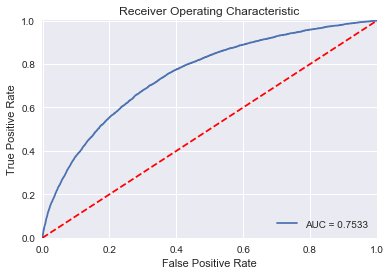

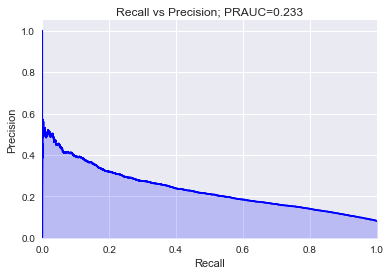

             precision    recall  f1-score   support

          N       0.96      0.76      0.85     70621
          Y       0.18      0.60      0.28      6256

avg / total       0.89      0.75      0.80     76877



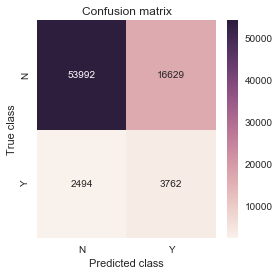

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.753,0.233,0.227,0.184,0.601,0.282


In [9]:
y_true = val_y
y_score = vanillanet.predict(val_X)
y_pred = y_score > cutoff_pred 
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 10)

In [10]:
vanillanet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.3085 - acc: 0.9213 - val_loss: 0.3257 - val_acc: 0.9185
Epoch 2/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.2967 - acc: 0.9220 - val_loss: 0.3183 - val_acc: 0.9180
Epoch 3/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.2879 - acc: 0.9222 - val_loss: 0.3150 - val_acc: 0.9177
Epoch 4/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.2806 - acc: 0.9228 - val_loss: 0.3117 - val_acc: 0.9180
Epoch 5/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.2734 - acc: 0.9236 - val_loss: 0.3099 - val_acc: 0.9173


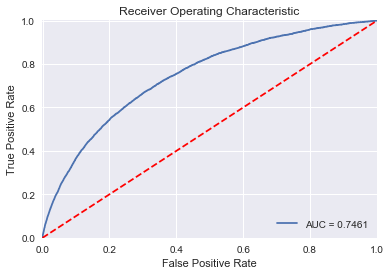

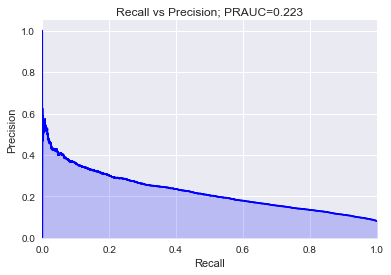

             precision    recall  f1-score   support

          N       0.95      0.79      0.87     70621
          Y       0.19      0.55      0.29      6256

avg / total       0.89      0.77      0.82     76877



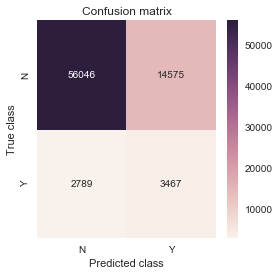

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.746,0.223,0.224,0.192,0.554,0.285


In [11]:
y_true = val_y
y_score = vanillanet.predict(val_X)
y_pred = y_score > cutoff_pred
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 15)

In [12]:
vanillanet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.2672 - acc: 0.9244 - val_loss: 0.3099 - val_acc: 0.9159
Epoch 2/5
230630/230630 [==============================] - 8s 36us/step - loss: 0.2623 - acc: 0.9249 - val_loss: 0.3087 - val_acc: 0.9162
Epoch 3/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.2577 - acc: 0.9257 - val_loss: 0.3098 - val_acc: 0.9162
Epoch 4/5
230630/230630 [==============================] - 8s 36us/step - loss: 0.2530 - acc: 0.9266 - val_loss: 0.3122 - val_acc: 0.9154
Epoch 5/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.2485 - acc: 0.9274 - val_loss: 0.3141 - val_acc: 0.9142


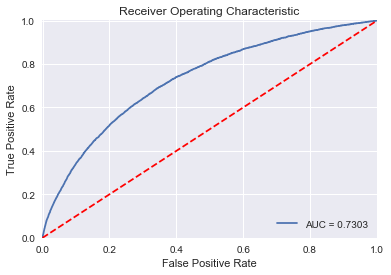

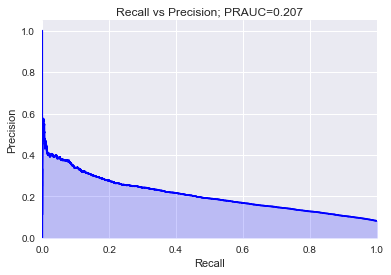

             precision    recall  f1-score   support

          N       0.95      0.79      0.86     70621
          Y       0.18      0.53      0.27      6256

avg / total       0.89      0.77      0.82     76877



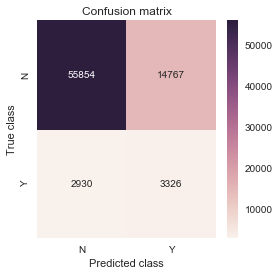

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.73,0.207,0.208,0.184,0.532,0.273


In [13]:
y_true = val_y
y_score = vanillanet.predict(val_X)
y_pred = y_score > cutoff_pred   
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 20)

In [14]:
vanillanet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.2446 - acc: 0.9287 - val_loss: 0.3168 - val_acc: 0.9139
Epoch 2/5
230630/230630 [==============================] - 9s 37us/step - loss: 0.2413 - acc: 0.9291 - val_loss: 0.3165 - val_acc: 0.9127
Epoch 3/5
230630/230630 [==============================] - 8s 36us/step - loss: 0.2379 - acc: 0.9297 - val_loss: 0.3195 - val_acc: 0.9109
Epoch 4/5
230630/230630 [==============================] - 9s 38us/step - loss: 0.2346 - acc: 0.9309 - val_loss: 0.3227 - val_acc: 0.9095
Epoch 5/5
230630/230630 [==============================] - 8s 36us/step - loss: 0.2317 - acc: 0.9316 - val_loss: 0.3258 - val_acc: 0.9105


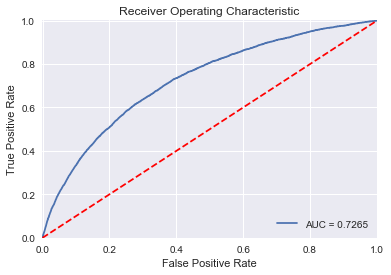

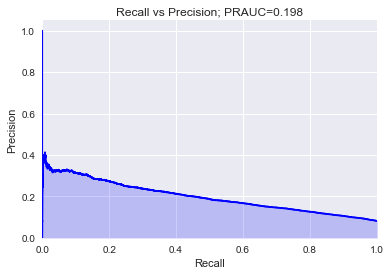

             precision    recall  f1-score   support

          N       0.95      0.81      0.87     70621
          Y       0.19      0.50      0.27      6256

avg / total       0.89      0.78      0.82     76877



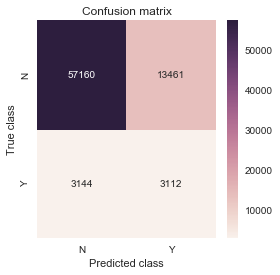

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.727,0.198,0.204,0.188,0.497,0.273


In [15]:
y_true = val_y
y_score = vanillanet.predict(val_X)
y_pred = y_score > cutoff_pred   
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

<br>

## 3. ResNet
---

### Training&Prediction (~Epoch 5)

In [16]:
model_input = Input(shape=(input_dim,))
model_input_noise = GaussianNoise(0.1)(model_input) 

hidden_1st = Dense(200, kernel_initializer='he_normal', activation='elu', activity_regularizer=regularizers.l2(1e-5))(model_input_noise)
hidden_dims = [200, 100, 50]
model_output = make_resnet(hidden_1st, hidden_dims)
resnet = Model(inputs=[model_input], outputs=[model_output], name="DenseNet")
SVG(model_to_dot(resnet, show_shapes=True).create(prog='dot', format='svg'))

optimizer_discriminator = Adam(1e-4, clipvalue=0.5)
resnet.compile(loss=['binary_crossentropy'], optimizer=optimizer_discriminator, metrics=['accuracy'])
resnet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 12s 50us/step - loss: 1.1469 - acc: 0.9107 - val_loss: 0.8070 - val_acc: 0.9187
Epoch 2/5
230630/230630 [==============================] - 10s 45us/step - loss: 0.6928 - acc: 0.9193 - val_loss: 0.5704 - val_acc: 0.9186
Epoch 3/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.5281 - acc: 0.9195 - val_loss: 0.4701 - val_acc: 0.9185
Epoch 4/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.4445 - acc: 0.9196 - val_loss: 0.4062 - val_acc: 0.9186
Epoch 5/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.3942 - acc: 0.9197 - val_loss: 0.3687 - val_acc: 0.9188


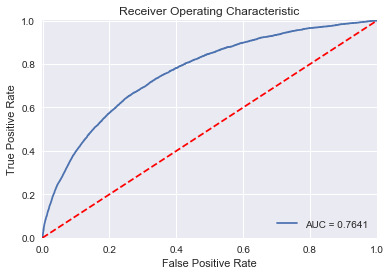

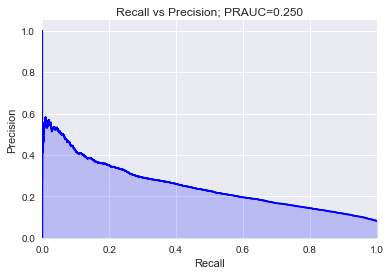

             precision    recall  f1-score   support

          N       0.96      0.77      0.85     70621
          Y       0.19      0.62      0.29      6256

avg / total       0.90      0.75      0.81     76877



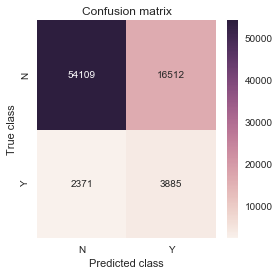

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.764,0.25,0.24,0.19,0.621,0.292


In [17]:
y_true = val_y
y_score = resnet.predict(val_X)
y_pred = y_score > cutoff_pred
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 10)

In [18]:
resnet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 10s 45us/step - loss: 0.3611 - acc: 0.9197 - val_loss: 0.3444 - val_acc: 0.9188
Epoch 2/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.3386 - acc: 0.9199 - val_loss: 0.3244 - val_acc: 0.9187
Epoch 3/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.3225 - acc: 0.9200 - val_loss: 0.3108 - val_acc: 0.9188
Epoch 4/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.3099 - acc: 0.9201 - val_loss: 0.3020 - val_acc: 0.9187
Epoch 5/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.3007 - acc: 0.9201 - val_loss: 0.2953 - val_acc: 0.9187


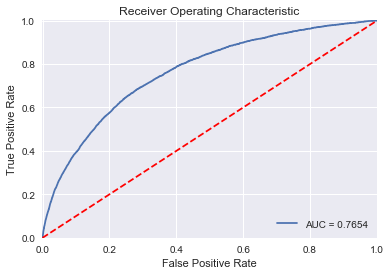

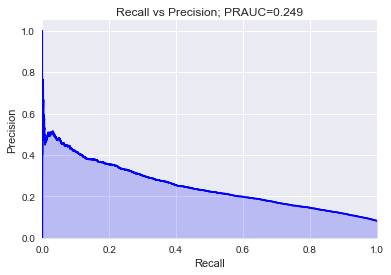

             precision    recall  f1-score   support

          N       0.96      0.74      0.83     70621
          Y       0.18      0.66      0.29      6256

avg / total       0.90      0.73      0.79     76877



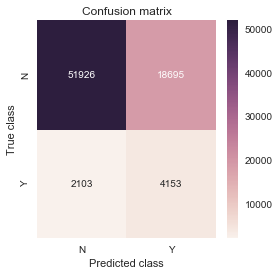

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.765,0.249,0.239,0.182,0.664,0.285


In [19]:
y_true = val_y
y_score = resnet.predict(val_X)
y_pred = y_score > cutoff_pred 
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 15)

In [20]:
resnet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 10s 45us/step - loss: 0.2927 - acc: 0.9201 - val_loss: 0.2878 - val_acc: 0.9190
Epoch 2/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.2865 - acc: 0.9202 - val_loss: 0.2846 - val_acc: 0.9187
Epoch 3/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.2817 - acc: 0.9200 - val_loss: 0.2794 - val_acc: 0.9187
Epoch 4/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.2778 - acc: 0.9200 - val_loss: 0.2765 - val_acc: 0.9186
Epoch 5/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.2739 - acc: 0.9200 - val_loss: 0.2737 - val_acc: 0.9191


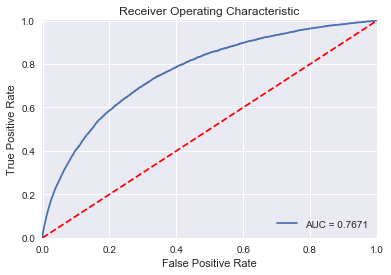

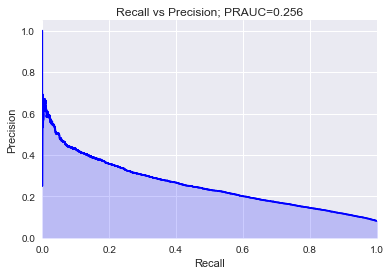

             precision    recall  f1-score   support

          N       0.96      0.76      0.85     70621
          Y       0.19      0.64      0.29      6256

avg / total       0.90      0.75      0.80     76877



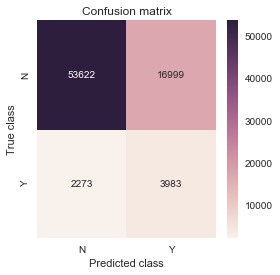

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.767,0.256,0.243,0.19,0.637,0.292


In [21]:
y_true = val_y
y_score = resnet.predict(val_X)
y_pred = y_score > cutoff_pred   
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 20)

In [22]:
resnet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 10s 45us/step - loss: 0.2711 - acc: 0.9202 - val_loss: 0.2714 - val_acc: 0.9187
Epoch 2/5
230630/230630 [==============================] - 11s 46us/step - loss: 0.2683 - acc: 0.9201 - val_loss: 0.2702 - val_acc: 0.9186
Epoch 3/5
230630/230630 [==============================] - 12s 51us/step - loss: 0.2666 - acc: 0.9200 - val_loss: 0.2688 - val_acc: 0.9187
Epoch 4/5
230630/230630 [==============================] - 12s 52us/step - loss: 0.2644 - acc: 0.9200 - val_loss: 0.2685 - val_acc: 0.9188
Epoch 5/5
230630/230630 [==============================] - 12s 51us/step - loss: 0.2628 - acc: 0.9201 - val_loss: 0.2649 - val_acc: 0.9188


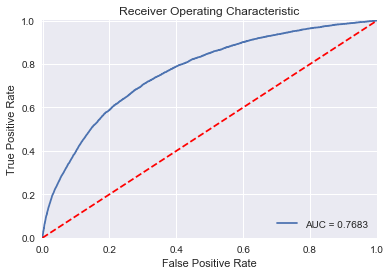

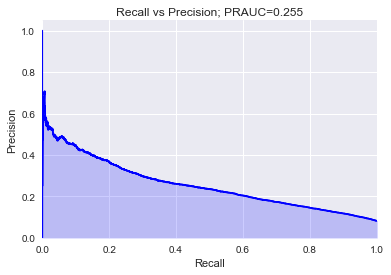

             precision    recall  f1-score   support

          N       0.96      0.76      0.85     70621
          Y       0.19      0.64      0.29      6256

avg / total       0.90      0.75      0.80     76877



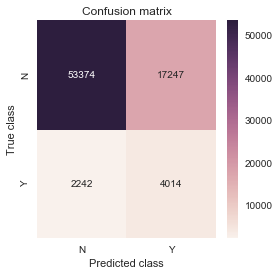

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.768,0.255,0.243,0.189,0.642,0.292


In [23]:
y_true = val_y
y_score = resnet.predict(val_X)
y_pred = y_score > cutoff_pred 
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

<br>
## 4. HighwayNet
---

### Training&Prediction (~Epoch 5)

In [24]:
model_input = Input(shape=(input_dim,))
model_input_noise = keras.layers.GaussianNoise(0.1)(model_input)

hidden_1st = Dense(200, kernel_initializer='he_normal', activation='elu', activity_regularizer=regularizers.l2(1e-5))(model_input_noise)
model_output = make_highwaynet(hidden_1st, hidden_dims)
highwaynet = Model(inputs=[model_input], outputs=[model_output], name="HighwayNet")
SVG(model_to_dot(highwaynet, show_shapes=True).create(prog='dot', format='svg'))

optimizer_discriminator = Adam(1e-4, clipvalue=0.5)
highwaynet.compile(loss=['binary_crossentropy'], optimizer=optimizer_discriminator, metrics=['accuracy'])
highwaynet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 18s 76us/step - loss: 1.2120 - acc: 0.9155 - val_loss: 0.8158 - val_acc: 0.9187
Epoch 2/5
230630/230630 [==============================] - 14s 62us/step - loss: 0.7137 - acc: 0.9194 - val_loss: 0.5909 - val_acc: 0.9189
Epoch 3/5
230630/230630 [==============================] - 14s 60us/step - loss: 0.5519 - acc: 0.9198 - val_loss: 0.4851 - val_acc: 0.9189
Epoch 4/5
230630/230630 [==============================] - 14s 60us/step - loss: 0.4626 - acc: 0.9199 - val_loss: 0.4191 - val_acc: 0.9190
Epoch 5/5
230630/230630 [==============================] - 14s 59us/step - loss: 0.4050 - acc: 0.9201 - val_loss: 0.3767 - val_acc: 0.9190


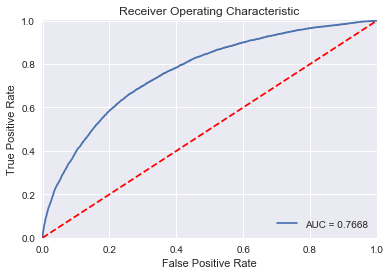

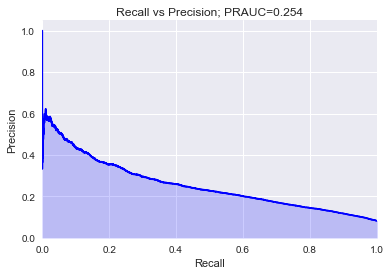

             precision    recall  f1-score   support

          N       0.96      0.75      0.84     70621
          Y       0.19      0.65      0.29      6256

avg / total       0.90      0.74      0.80     76877



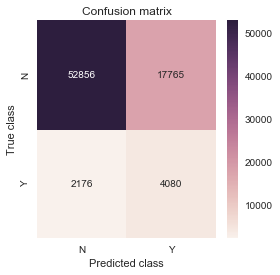

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.767,0.254,0.243,0.187,0.652,0.29


In [25]:
y_true = val_y
y_score = highwaynet.predict(val_X)
y_pred = y_score > cutoff_pred
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 10)

In [26]:
highwaynet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 14s 59us/step - loss: 0.3665 - acc: 0.9200 - val_loss: 0.3465 - val_acc: 0.9190
Epoch 2/5
230630/230630 [==============================] - 14s 60us/step - loss: 0.3403 - acc: 0.9201 - val_loss: 0.3258 - val_acc: 0.9189
Epoch 3/5
230630/230630 [==============================] - 14s 59us/step - loss: 0.3216 - acc: 0.9202 - val_loss: 0.3113 - val_acc: 0.9189
Epoch 4/5
230630/230630 [==============================] - 14s 61us/step - loss: 0.3077 - acc: 0.9202 - val_loss: 0.3010 - val_acc: 0.9187
Epoch 5/5
230630/230630 [==============================] - 14s 62us/step - loss: 0.2973 - acc: 0.9202 - val_loss: 0.2915 - val_acc: 0.9193


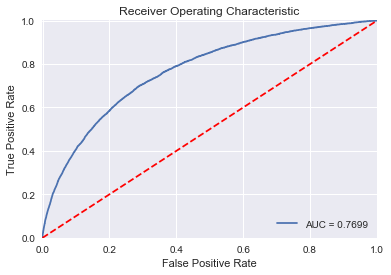

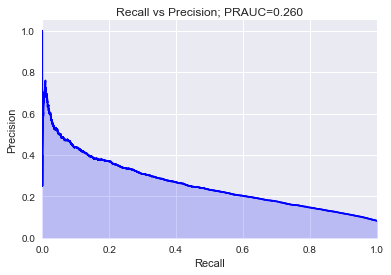

             precision    recall  f1-score   support

          N       0.96      0.78      0.86     70621
          Y       0.20      0.61      0.30      6256

avg / total       0.90      0.77      0.82     76877



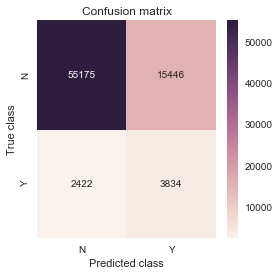

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.77,0.26,0.249,0.199,0.613,0.3


In [27]:
y_true = val_y
y_score = highwaynet.predict(val_X)
y_pred = y_score > cutoff_pred
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 15)

In [28]:
highwaynet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 14s 59us/step - loss: 0.2893 - acc: 0.9202 - val_loss: 0.2860 - val_acc: 0.9193
Epoch 2/5
230630/230630 [==============================] - 15s 63us/step - loss: 0.2828 - acc: 0.9204 - val_loss: 0.2817 - val_acc: 0.9186
Epoch 3/5
230630/230630 [==============================] - 14s 61us/step - loss: 0.2778 - acc: 0.9205 - val_loss: 0.2768 - val_acc: 0.9191
Epoch 4/5
230630/230630 [==============================] - 14s 62us/step - loss: 0.2738 - acc: 0.9205 - val_loss: 0.2750 - val_acc: 0.9191
Epoch 5/5
230630/230630 [==============================] - 14s 61us/step - loss: 0.2704 - acc: 0.9203 - val_loss: 0.2723 - val_acc: 0.9190


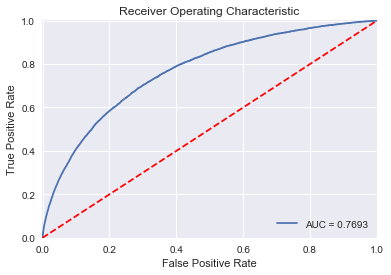

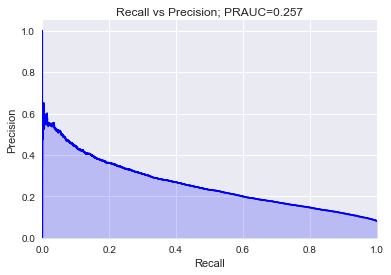

             precision    recall  f1-score   support

          N       0.96      0.77      0.86     70621
          Y       0.19      0.62      0.30      6256

avg / total       0.90      0.76      0.81     76877



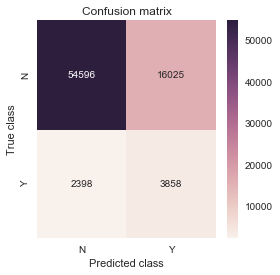

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.769,0.257,0.243,0.194,0.617,0.295


In [29]:
y_true = val_y
y_score = highwaynet.predict(val_X)
y_pred = y_score > cutoff_pred
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 20)

In [30]:
highwaynet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 14s 60us/step - loss: 0.2678 - acc: 0.9205 - val_loss: 0.2707 - val_acc: 0.9188
Epoch 2/5
230630/230630 [==============================] - 14s 62us/step - loss: 0.2652 - acc: 0.9205 - val_loss: 0.2686 - val_acc: 0.9187
Epoch 3/5
230630/230630 [==============================] - 14s 60us/step - loss: 0.2634 - acc: 0.9209 - val_loss: 0.2687 - val_acc: 0.9188
Epoch 4/5
230630/230630 [==============================] - 14s 60us/step - loss: 0.2616 - acc: 0.9208 - val_loss: 0.2675 - val_acc: 0.9191
Epoch 5/5
230630/230630 [==============================] - 14s 59us/step - loss: 0.2599 - acc: 0.9212 - val_loss: 0.2688 - val_acc: 0.9182


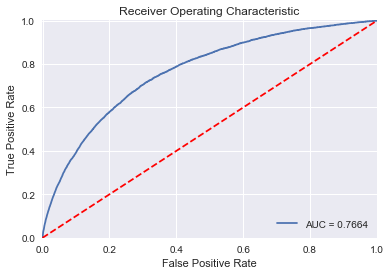

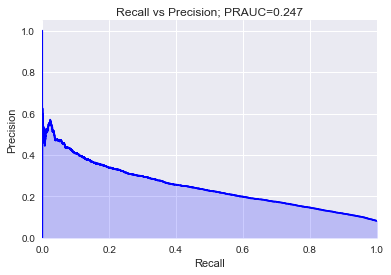

             precision    recall  f1-score   support

          N       0.96      0.76      0.85     70621
          Y       0.19      0.64      0.29      6256

avg / total       0.90      0.75      0.80     76877



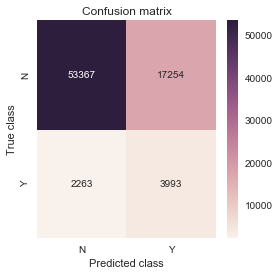

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.766,0.247,0.241,0.188,0.638,0.29


In [31]:
y_true = val_y
y_score = highwaynet.predict(val_X)
y_pred = y_score > cutoff_pred 
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

<br>
## 5. DenseNet
---

### Training&Prediction (~Epoch 5)

In [32]:
model_input = Input(shape=(input_dim,))
model_input_noise = GaussianNoise(0.1)(model_input)

hidden_1st = Dense(200, kernel_initializer='he_normal', activation='elu', activity_regularizer=regularizers.l2(1e-5))(model_input_noise)
hidden_dims = [200, 100, 50]
model_output = make_densenet(hidden_1st, hidden_dims)
densenet = Model(inputs=[model_input], outputs=[model_output], name="DenseNet")
#SVG(model_to_dot(densenet, show_shapes=True).create(prog='dot', format='svg'))

optimizer_discriminator = Adam(1e-4, clipvalue=0.5)
densenet.compile(loss=['binary_crossentropy'], optimizer=optimizer_discriminator, metrics=['accuracy'])
densenet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 17s 72us/step - loss: 0.9861 - acc: 0.9167 - val_loss: 0.6738 - val_acc: 0.9186
Epoch 2/5
230630/230630 [==============================] - 15s 65us/step - loss: 0.5918 - acc: 0.9196 - val_loss: 0.4936 - val_acc: 0.9190
Epoch 3/5
230630/230630 [==============================] - 15s 66us/step - loss: 0.4663 - acc: 0.9199 - val_loss: 0.4156 - val_acc: 0.9190
Epoch 4/5
230630/230630 [==============================] - 15s 64us/step - loss: 0.4028 - acc: 0.9199 - val_loss: 0.3714 - val_acc: 0.9189
Epoch 5/5
230630/230630 [==============================] - 15s 64us/step - loss: 0.3646 - acc: 0.9199 - val_loss: 0.3435 - val_acc: 0.9190


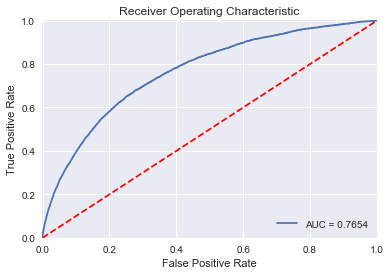

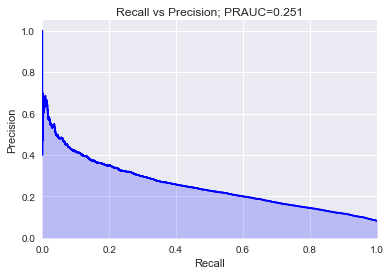

             precision    recall  f1-score   support

          N       0.96      0.78      0.86     70621
          Y       0.20      0.60      0.30      6256

avg / total       0.90      0.77      0.82     76877



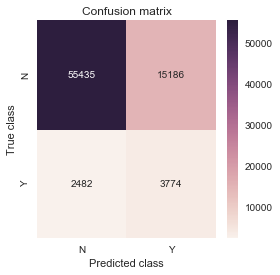

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.765,0.251,0.246,0.199,0.603,0.299


In [33]:
y_true = val_y
y_score = densenet.predict(val_X)
y_pred = y_score > cutoff_pred
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 10)

In [34]:
densenet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 15s 65us/step - loss: 0.3395 - acc: 0.9199 - val_loss: 0.3241 - val_acc: 0.9189
Epoch 2/5
230630/230630 [==============================] - 15s 65us/step - loss: 0.3221 - acc: 0.9199 - val_loss: 0.3091 - val_acc: 0.9191
Epoch 3/5
230630/230630 [==============================] - 16s 69us/step - loss: 0.3094 - acc: 0.9201 - val_loss: 0.3000 - val_acc: 0.9189
Epoch 4/5
230630/230630 [==============================] - 18s 78us/step - loss: 0.3000 - acc: 0.9201 - val_loss: 0.2919 - val_acc: 0.9189
Epoch 5/5
230630/230630 [==============================] - 18s 78us/step - loss: 0.2924 - acc: 0.9202 - val_loss: 0.2873 - val_acc: 0.9190


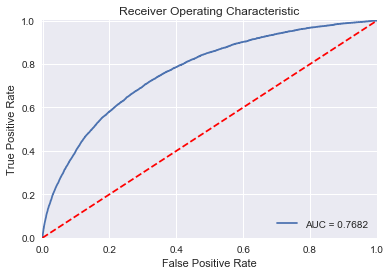

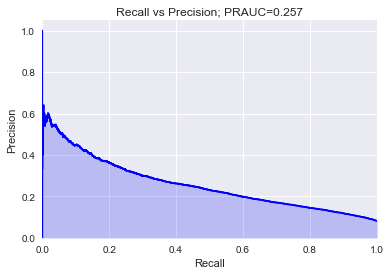

             precision    recall  f1-score   support

          N       0.96      0.77      0.85     70621
          Y       0.19      0.62      0.29      6256

avg / total       0.90      0.75      0.81     76877



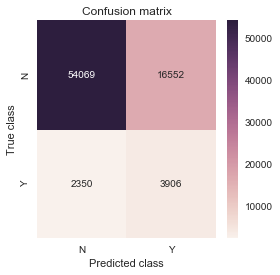

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.768,0.257,0.241,0.191,0.624,0.292


In [35]:
y_true = val_y
y_score = densenet.predict(val_X)
y_pred = y_score > cutoff_pred  
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 15)

In [36]:
densenet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 16s 69us/step - loss: 0.2865 - acc: 0.9201 - val_loss: 0.2820 - val_acc: 0.9188
Epoch 2/5
230630/230630 [==============================] - 15s 67us/step - loss: 0.2814 - acc: 0.9202 - val_loss: 0.2795 - val_acc: 0.9191
Epoch 3/5
230630/230630 [==============================] - 16s 70us/step - loss: 0.2773 - acc: 0.9205 - val_loss: 0.2757 - val_acc: 0.9192
Epoch 4/5
230630/230630 [==============================] - 15s 65us/step - loss: 0.2736 - acc: 0.9204 - val_loss: 0.2725 - val_acc: 0.9192
Epoch 5/5
230630/230630 [==============================] - 15s 65us/step - loss: 0.2703 - acc: 0.9205 - val_loss: 0.2708 - val_acc: 0.9191


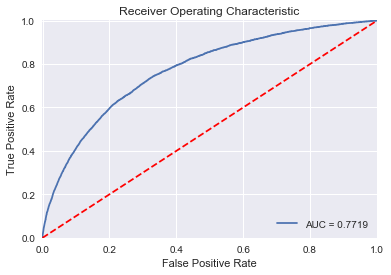

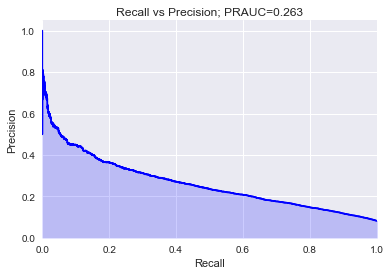

             precision    recall  f1-score   support

          N       0.96      0.77      0.86     70621
          Y       0.20      0.63      0.30      6256

avg / total       0.90      0.76      0.81     76877



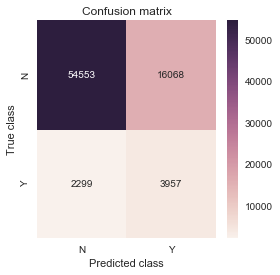

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.772,0.263,0.252,0.198,0.633,0.301


In [37]:
y_true = val_y
y_score = densenet.predict(val_X)
y_pred = y_score > cutoff_pred    
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

### Training&Prediction (~Epoch 20)

In [38]:
densenet.fit(train_X, train_y, epochs=5, batch_size=256, shuffle=True, validation_data=(val_X, val_y))

Train on 230630 samples, validate on 76877 samples
Epoch 1/5
230630/230630 [==============================] - 16s 71us/step - loss: 0.2681 - acc: 0.9205 - val_loss: 0.2699 - val_acc: 0.9191
Epoch 2/5
230630/230630 [==============================] - 17s 75us/step - loss: 0.2656 - acc: 0.9204 - val_loss: 0.2690 - val_acc: 0.9187
Epoch 3/5
230630/230630 [==============================] - 17s 72us/step - loss: 0.2637 - acc: 0.9204 - val_loss: 0.2674 - val_acc: 0.9190
Epoch 4/5
230630/230630 [==============================] - 17s 72us/step - loss: 0.2615 - acc: 0.9206 - val_loss: 0.2674 - val_acc: 0.9188
Epoch 5/5
230630/230630 [==============================] - 16s 67us/step - loss: 0.2601 - acc: 0.9206 - val_loss: 0.2659 - val_acc: 0.9190


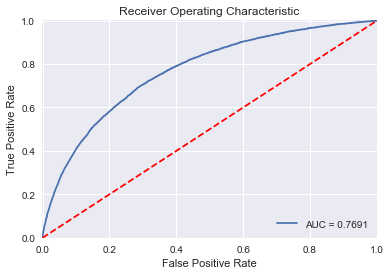

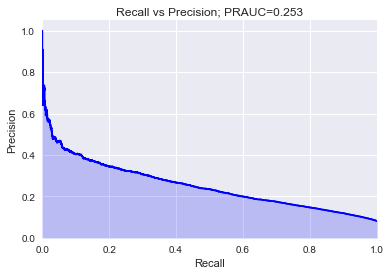

             precision    recall  f1-score   support

          N       0.96      0.77      0.85     70621
          Y       0.19      0.62      0.29      6256

avg / total       0.90      0.76      0.81     76877



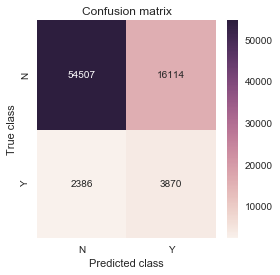

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.769,0.253,0.243,0.194,0.619,0.295


In [39]:
y_true = val_y
y_score = densenet.predict(val_X)
y_pred = y_score > cutoff_pred 
metrics = hcc_eval.get_binary_classification_results_all_in_one(y_true, y_score, y_pred)
display(metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 703)          0                                            
__________________________________________________________________________________________________
gaussian_noise_4 (GaussianNoise (None, 703)          0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 200)          140800      gaussian_noise_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 200)          800         dense_26[0][0]                   
__________________________________________________________________________________________________
dense_27 (

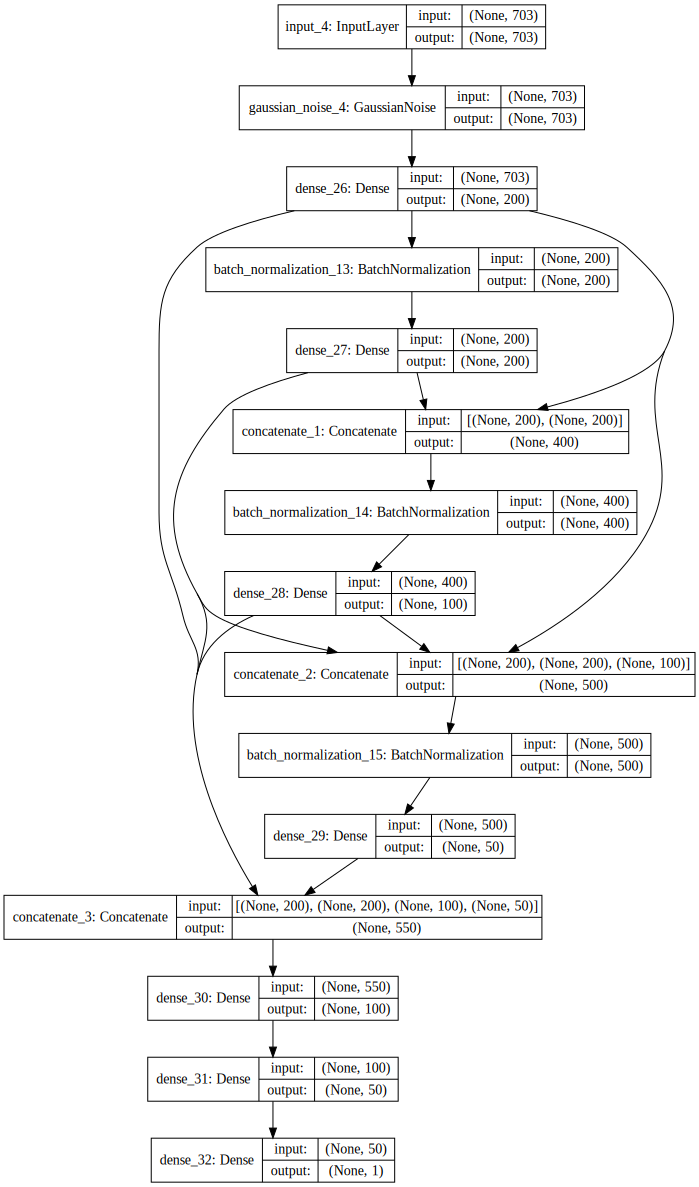

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

print(densenet.summary())
display(SVG(model_to_dot(densenet, show_shapes=True).create(prog='dot', format='svg')))